<a href="https://colab.research.google.com/github/samsonq/AdaptiveKDE/blob/master/SPRT_LM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
import math
import scipy as sp

In [ ]:
!pip install sprt

  Created wheel for sprt: filename=sprt-0.0.1-py3-none-any.whl size=4036 sha256=78cbdfc629cdf1acd103a1b7f3d0b260ce52be6cd7302f560576bfa7670552a3
  Stored in directory: /root/.cache/pip/wheels/8d/2d/0c/d0736d530abed996fcbfbe0aacc965e314249bd43af3b24c70
Successfully built sprt


In [ ]:
import abc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import sys


# SPRT test
class SPRT:

    __metaclass__ = abc.ABCMeta
  
    """Run sequential probability ratio test (SPRT) for bindary/normal endpoints"""
    # Init function
    def __init__(self, alpha=0.05, beta=0.2,
                 h0=0, h1=1, values=[], variance=0):

        # Input arguments
        self.alpha = alpha
        self.beta = beta
        self.h0 = h0
        self.h1 = h1
        self.values = values
        self.cum_values = np.cumsum(self.values)
        self.variance = variance
        # Necessary arguments
        self.upperCritical = np.log((1 - self.beta)/self.alpha)
        self.lowerCritical = np.log(self.beta/(1 - self.alpha))
        self.num_observation = len(values)
        self._seq_observation = np.array(range(1, self.num_observation + 1))
        self._x = np.array(range(0, self.num_observation + 2))
        self._yl = self._yu = np.ones(self.num_observation + 2)
        self.decision = None
        # Check the arguments
        self.__checkCommonArgs()
        self.__checkOtherArgs()
        # Calculate boundary
        self.calBoundary()
        # Sequential test
        self.seqTest()

    # Check common arguments in the fuction
    def __checkCommonArgs(self):

        if not all(0 < i < 1 for i in [self.alpha, self.beta]):

            sys.stderr.write("Type I error rate and type II error rate are between 0 and 1!")
            sys.exit(1)

    # Plot the boundary and points
    def plot(self, boundaryColor=["#00aedb", "#d41243",  "#000000"],  pointColor="#000000", fill=True):

        lowerBoundaryColor, upperBoundaryColor, continueColor = boundaryColor
        fig, ax = plt.subplots(figsize=(8, 6))
        lower_line, = ax.plot(self._x, self._yl, color=lowerBoundaryColor, linewidth=1, alpha=0.95)
        upper_line, = ax.plot(self._x, self._yu, color=upperBoundaryColor,  linewidth=1,  alpha=0.95)
        ax.scatter(self._seq_observation, self.cum_values, color=pointColor, zorder=1000, clip_on=False)
        yticks, yticklabels = plt.yticks()
        ymin = yticks[0]
        ymax = yticks[-1]
        if fill:

            ax.fill_between(self._x, self._yl, ymin, color=lowerBoundaryColor, alpha=0.5)
            ax.fill_between(self._x, self._yu, ymax, color=upperBoundaryColor, alpha=0.5)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        xticks, xticklabels = plt.xticks()
        xmin = 0.95
        xmax = self.num_observation + 0.05
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.xlabel("Observations")
        plt.ylabel("Cumulative Sum")
        plt.legend(handles=[upper_line, lower_line], labels=["Reject Null", "Accept Null"], fontsize=10, loc=2)
        plt.show()

    # Plot only the boundary values
    def plotBoundary(self, boundaryColor=["#00aedb", "#d41243"],  fill=True):

        lowerBoundaryColor, upperBoundaryColor = boundaryColor
        fig, ax = plt.subplots(figsize=(8, 6))
        lower_line, = ax.plot(self._x, self._yl, color=lowerBoundaryColor, linewidth=1)
        upper_line, = ax.plot(self._x, self._yu, color=upperBoundaryColor, linewidth=1)
        yticks, yticklabels = plt.yticks()
        ymin = yticks[0]
        ymax = yticks[-1]
        if fill:

            ax.fill_between(self._x, self._yl, ymin, color=lowerBoundaryColor, alpha=0.5)
            ax.fill_between(self._x, self._yu, ymax, color=upperBoundaryColor, alpha=0.5)

        ax.spines["top"].set_visible(False) 
        ax.spines["right"].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        plt.xlim(1, self.num_observation)
        plt.ylim(ymin, ymax)
        plt.xlabel("Observations")
        plt.ylabel("Cumulative Sum")
        plt.legend(handles = [upper_line, lower_line], labels=["Reject Null", "Accept Null"], fontsize = 10, loc = 2)
        plt.show()

    # Get test result
    def getResult(self, nobs=5, start="end"):

        print("Decision:\t" + self.decision + "\n")
        output_dict = {'values': self.cum_values, 'lower': self.lowerBoundary, 'upper': self.upperBoundary}
        output_df = pd.DataFrame(output_dict, columns=['values', 'lower', 'upper'], index=self._seq_observation)
        output_df.index.name = "n"
        print(output_df.round(3).iloc[-nobs:])

    # Sequential test
    def seqTest(self):

        self.test_statistic = self.cum_values[self.num_observation - 1]
        if self.test_statistic > self.upperBoundary[self.num_observation - 1]:

            self.decision = "Reject"

        elif self.test_statistic < self.lowerBoundary[self.num_observation - 1]:

            self.decision = "Accept"

        else:

            self.decision = "Continue"

        header = 10 if self.num_observation > 10 else self.num_observation
        self.getResult(nobs=header)

    # Abstract method, calculate the boundary by time
    @abc.abstractmethod
    def calBoundary(self):

        return

    # Abstarct method, function to check other input arguments
    @abc.abstractmethod
    def __checkOtherArgs(self):

        return


# Binary Endpoint
class SPRTBinomial(SPRT):

    """Run sequential probability ratio test (SPRT) for bindary endpoints"""
    # Calculate boundary for binary outcome
    def calBoundary(self):

        self.denom = (np.log(self.h1/(1 - self.h1)) - np.log(self.h0/(1 - self.h0)))
        self.slope = (np.log(1 - self.h0) - np.log(1 - self.h1)) / self.denom
        self.lowerIntercept, self.upperIntercept = np.array([self.lowerCritical, self.upperCritical]) / self.denom
        self.lowerBoundary = self._seq_observation * self.slope + self.lowerIntercept
        self.upperBoundary = self._seq_observation * self.slope + self.upperIntercept
        self._yl = self._x * self.slope + self.lowerIntercept
        self._yu = self._x * self.slope + self.upperIntercept

    # Check arguments
    def _SPRT__checkOtherArgs(self):

        # Check h0 and h1
        if not all(0 < i < 1 for i in [self.h0, self.h1]):

            sys.stderr.write("Null and alternative values are between 0 and 1!")
            sys.exit(1)

        # Check values
        if not all(i in [0, 1] for i in self.values):

            sys.stderr.write("Value is a Beroulli variable!")
            sys.exit(1)


# Normal Endpoint
class SPRTNormal(SPRT):

    """Run sequential probability ratio test (SPRT) for normal endpoints"""
    # Calculate boundary for normal outcome
    def calBoundary(self):

        self.slope = (self.h1 + self.h0)/2
        self.lowerIntercept, self.upperIntercept = np.array([self.lowerCritical, self.upperCritical]) * self.variance / (self.h1 - self.h0)
        self.lowerBoundary = self._seq_observation * self.slope + self.lowerIntercept
        self.upperBoundary = self._seq_observation * self.slope + self.upperIntercept
        self._yl = self._x * self.slope + self.lowerIntercept
        self._yu = self._x * self.slope + self.upperIntercept

    # Check arguments
    def _SPRT__checkOtherArgs(self):

        # Check variance
        if self.variance <= 0:

            sys.stderr.write("Variance of normal distribution is positive!")
            sys.exit(1)


In [ ]:
df.shape

NameError: ignored

In [ ]:
## Calculating the initial distance metric: 
# https://www.machinelearningplus.com/statistics/mahalanobis-distance/

In [ ]:
import scipy.optimize
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = scipy.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()


In [ ]:
delta_dist = mahalanobis(x=df, data=df[['carat', 'depth', 'price']]) # this is the existing distance metric (distribution)

In [ ]:
## we will now fit distribution (PARAMETRIC) and determine the probability that that value is less than gamma (fixed value)

In [ ]:
# SPRT 
# Binomial Endpoints
import sprt as sprt
import numpy as np

h0 = 0.5
h1 = 0.55
# Type I error rate = 0.05
alpha = 0.05
# Type II error rate = 0.2
beta = 0.2
# Values
values = np.random.binomial(1, 0.55, 100)
test = sprt.SPRTBinomial(h0 = h0, h1 = h1, alpha = alpha, beta = beta, values = values)

Decision:	Continue

     values   lower   upper
n                          
91       48  40.014  61.595
92       49  40.539  62.120
93       50  41.064  62.646
94       50  41.589  63.171
95       50  42.114  63.696
96       50  42.639  64.221
97       50  43.164  64.746
98       50  43.689  65.271
99       51  44.214  65.796
100      52  44.740  66.321


In [ ]:
## the method converges after we have hit a particular value for the Lambda parameter

In [ ]:
%matplotlib inline
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.distributions.mixture_rvs import mixture_rvs

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
np.random.seed(12345)

In [ ]:
### BELOW WE HAVE A BINOMIAL DISTRIBUTION: a combination of two normal distributions

In [ ]:
# https://www.statsmodels.org/stable/examples/notebooks/generated/kernel_density.html

In [ ]:

# Location, scale and weight for the two distributions
dist1_loc, dist1_scale, weight1 = -1, 0.5, 0.40
dist2_loc, dist2_scale, weight2 = 1, 0.5, 0.60

# Sample from a mixture of distributions
obs_dist = mixture_rvs(
    prob=[weight1, weight2],
    size=250,
    dist=[stats.norm, stats.norm],
    kwargs=(
        dict(loc=dist1_loc, scale=dist1_scale),
        dict(loc=dist2_loc, scale=dist2_scale),
    ),
)

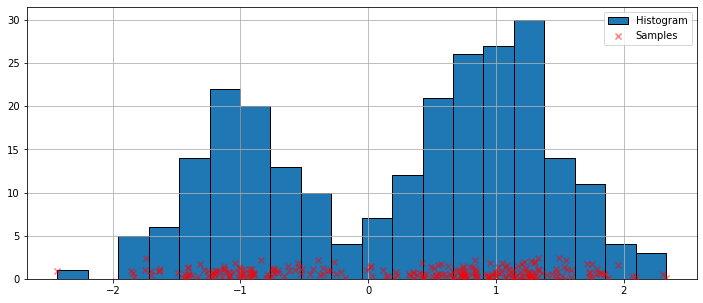

In [ ]:

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

# Scatter plot of data samples and histogram
ax.scatter(
    obs_dist,
    np.abs(np.random.randn(obs_dist.size)),
    zorder=15,
    color="red",
    marker="x",
    alpha=0.5,
    label="Samples",
)
lines = ax.hist(obs_dist, bins=20, edgecolor="k", label="Histogram")

ax.legend(loc="best")
ax.grid(True, zorder=-5)

In [ ]:
kde = sm.nonparametric.KDEUnivariate(obs_dist)
kde.fit()  # Estimate the densities

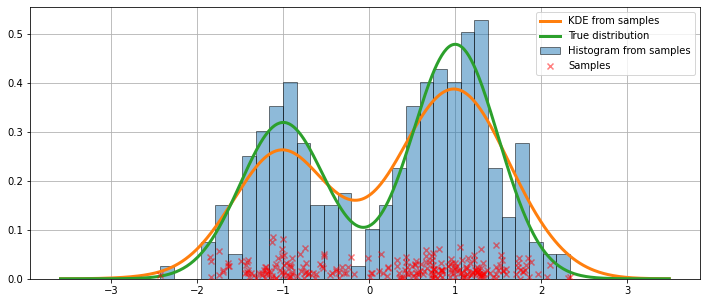

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

# Plot the histrogram
ax.hist(
    obs_dist,
    bins=30,
    density=True,
    label="Histogram from samples",
    zorder=5,
    edgecolor="k",
    alpha=0.5,
)

# Plot the KDE as fitted using the default arguments
ax.plot(kde.support, kde.density, lw=3, label="KDE from samples", zorder=10)

# Plot the true distribution
true_values = (
    stats.norm.pdf(loc=dist1_loc, scale=dist1_scale, x=kde.support) * weight1
    + stats.norm.pdf(loc=dist2_loc, scale=dist2_scale, x=kde.support) * weight2
)
ax.plot(kde.support, true_values, lw=3, label="True distribution", zorder=15)

# Plot the samples
ax.scatter(
    obs_dist,
    np.abs(np.random.randn(obs_dist.size)) / 40,
    marker="x",
    color="red",
    zorder=20,
    label="Samples",
    alpha=0.5,
)

ax.legend(loc="best")
ax.grid(True, zorder=-5)

In [ ]:
### WE CAN ALSO VARY THE BANDWIDTH

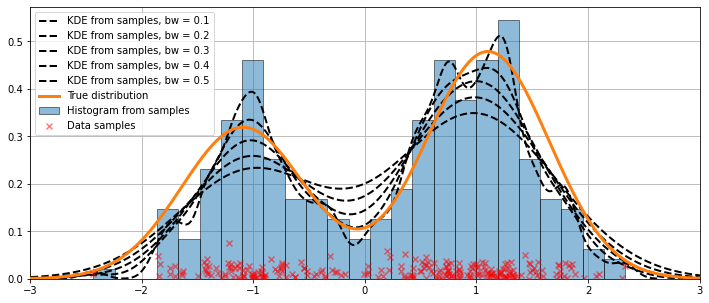

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

# Plot the histrogram
ax.hist(
    obs_dist,
    bins=25,
    label="Histogram from samples",
    zorder=5,
    edgecolor="k",
    density=True,
    alpha=0.5,
)

# Plot the KDE for various bandwidths
for bandwidth in [0.1, 0.2, 0.3, 0.4, 0.5]:
    kde.fit(bw=bandwidth)  # Estimate the densities
    ax.plot(
        kde.support,
        kde.density,
        "--",
        lw=2,
        color="k",
        zorder=10,
        label="KDE from samples, bw = {}".format(round(bandwidth, 2)),
    )

# Plot the true distribution
ax.plot(kde.support, true_values, lw=3, label="True distribution", zorder=15)

# Plot the samples
ax.scatter(
    obs_dist,
    np.abs(np.random.randn(obs_dist.size)) / 50,
    marker="x",
    color="red",
    zorder=20,
    label="Data samples",
    alpha=0.5,
)

ax.legend(loc="best")
ax.set_xlim([-3, 3])
ax.grid(True, zorder=-5)

In [ ]:
sampled = np.array(kde.density) ## this has now been sampled form the probability distribution we have fit on the data

In [ ]:
s2 = np.random.rand(512,)

df = pd.DataFrame([sampled, s2]).T


In [ ]:
df

,0,1
0,0.000126,0.142782
1,0.000121,0.402784
2,0.000118,0.220461
3,0.000116,0.980460
4,0.000114,0.577380
...,...,...
507,0.000166,0.704549
508,0.000155,0.547357
509,0.000146,0.113623
510,0.000138,0.543360


In [ ]:
delta_dist = np.array(mahalanobis(x=df, data=df.iloc[:,:])).reshape(-1,1)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
print(scaler.fit(delta_dist))
StandardScaler()
x = scaler.transform(delta_dist)

StandardScaler(copy=True, with_mean=True, with_std=True)


In [ ]:
x = x.reshape(512,)

In [ ]:
x

array([ 0.45791439, -0.59217234,  0.00543662,  1.81872348, -0.55336631,
       -0.31451573, -0.63149216,  1.06366886, -0.58612461, -0.40025402,
        0.0932778 ,  0.09645516, -0.44887697,  0.33804706,  1.90810567,
        0.33308044, -0.64891206, -0.62442422,  0.37580502, -0.37934471,
        0.01025965, -0.17062979,  0.89327341, -0.62127046,  0.74227822,
       -0.49472006,  0.97149916,  0.22960654,  1.64932278,  0.50504718,
       -0.54516474, -0.39717359,  0.16553249,  1.0914387 , -0.62117642,
       -0.60608088,  0.37356254,  0.03782392, -0.63522653,  0.78989487,
       -0.61528357,  0.05280043, -0.33391365,  0.44241892,  0.0383517 ,
       -0.35487089,  0.4791406 , -0.36257846, -0.66864289, -0.3281849 ,
        1.22123962, -0.56478314, -0.65302126,  0.41689703,  0.32996373,
       -0.10652857, -0.13815063, -0.49687908, -0.68894673,  0.04602798,
        0.94279079,  0.05814925,  0.46520505,  0.43286795, -0.70631152,
        0.23302345,  1.14464557,  1.40342687, -0.41219169, -0.08

In [ ]:
threshold = 0.30
prior_prob = np.sum(x > threshold) / x.shape[0]

In [ ]:
prior_prob

0.365234375

In [ ]:
# SPRT 
# Binomial Endpoints
import sprt as sprt
import numpy as np

h0 = prior_prob - 0.05
h1 = prior_prob + 0.05
# Type I error rate = 0.05
alpha = 0.05
# Type II error rate = 0.2
beta = 0.2
# Values
values = np.random.binomial(1, prior_prob, 100)
test = sprt.SPRTBinomial(h0 = h0, h1 = h1, alpha = alpha, beta = beta, values = values)

Decision:	Continue

     values   lower   upper
n                          
91       37  29.552  39.545
92       37  29.916  39.909
93       37  30.281  40.273
94       37  30.645  40.637
95       38  31.009  41.002
96       38  31.373  41.366
97       39  31.738  41.730
98       40  32.102  42.094
99       40  32.466  42.459
100      41  32.830  42.823


In [ ]:

norm_data

array(StandardScaler(copy=True, with_mean=True, with_std=True),
      dtype=object)

In [ ]:
import awkde

ModuleNotFoundError: ignored

In [ ]:

import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm

from awkde import GaussianKDE


ModuleNotFoundError: ignored